In [4]:
# %% [markdown]
# # 6-hour Ahead Consumption Forecasting - 4 Models
# Models: Linear Regression, Random Forest, XGBoost, LightGBM

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %% [markdown]
# ## 1. Load data

# %%
# 修改成你自己的路径
DATA_ROOT = r"D:\OneDrive - The University of Western Ontario\03 课程\ECE 9611\Project\code"
INPUT_PATH = os.path.join(DATA_ROOT, "6hour_interval", "smart_meter_6h_feature_engineered.csv")


print("Input:", INPUT_PATH)
df = pd.read_csv(INPUT_PATH)
df.columns = df.columns.str.strip()
print("Shape:", df.shape)
df.head()


Input: D:\OneDrive - The University of Western Ontario\03 课程\ECE 9611\Project\code\6hour_interval\smart_meter_6h_feature_engineered.csv
Shape: (462713, 55)


,household_ID,DATE,TIME,TOTAL_IMPORT (kWh),w1_hh_member_count,w1_hh_avg_age,w1_hh_num_children,w1_hh_num_seniors,w1_hh_avg_hours_home,w1_hh_share_went_out_for_work,...,next_import,delta_hours_next,future_6h_consumption,hour,dayofweek,month,prev_import,backward_6h_consumption,consumption_per_member,fan_density
0,ID0220,2023-01-01,1:11:16,2203.1041,2,66.5,0,2,165.0,0.0,...,2203.709,5.305000,0.6049,1,6,1,NaN,NaN,NaN,0.002
1,ID0220,2023-01-02,21:22:00,2209.0300,2,66.5,0,2,165.0,0.0,...,2209.764,4.347778,0.7340,21,0,1,2203.1041,0.134134,0.067067,0.002
2,ID0220,2023-01-03,1:42:52,2209.7640,2,66.5,0,2,165.0,0.0,...,2210.320,4.968056,0.5560,1,1,1,2209.0300,0.168822,0.084411,0.002
3,ID0220,2023-01-03,21:17:42,2212.8880,2,66.5,0,2,165.0,0.0,...,2213.847,4.462500,0.9590,21,1,1,2209.7640,0.159546,0.079773,0.002
4,ID0220,2023-01-04,1:45:27,2213.8470,2,66.5,0,2,165.0,0.0,...,2214.752,4.925556,0.9050,1,2,1,2212.8880,0.214902,0.107451,0.002


In [5]:
# %% [markdown]
# ## 2. Prepare target and feature columns

# %%
target_col = "future_6h_consumption"
if target_col not in df.columns:
    raise KeyError(f"列 '{target_col}' 不存在，请确认你已经构造了 future_6h_consumption 标签。")

# 丢掉没有标签的行
df = df.dropna(subset=[target_col]).copy()
print("After dropping rows with NaN label:", df.shape)

# 一些明显不适合作为特征的列
cols_to_drop = [
    target_col,
    "household_ID",
    "DATE",
    "TIME",
    "timestamp",
    "next_timestamp",
    "delta_hours_next",
    "prev_import",
    "TOTAL_IMPORT (kWh)",
    "next_import",
]



cols_to_drop = [c for c in cols_to_drop if c in df.columns]

# 去除有缺失值的行和NaN行
df = df.dropna().copy()

feature_df = df.drop(columns=cols_to_drop).copy()
print("Feature columns count:", feature_df.shape[1])
print("Feature columns:", feature_df.columns.tolist())


# 区分数值和类别特征
numeric_features = []
categorical_features = []

for col in feature_df.columns:
    if pd.api.types.is_numeric_dtype(feature_df[col]):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


After dropping rows with NaN label: (462713, 55)
Feature columns count: 45
Feature columns: ['w1_hh_member_count', 'w1_hh_avg_age', 'w1_hh_num_children', 'w1_hh_num_seniors', 'w1_hh_avg_hours_home', 'w1_hh_share_went_out_for_work', 'w1_num_fans', 'w1_fan_hours_day', 'w1_fan_hours_night', 'w1_num_lights', 'w1_light_total_wattage', 'w1_light_hours_day', 'w1_light_hours_night', 'w1_num_rooms', 'w1_total_windows', 'w1_total_doors_ext', 'w1_total_room_bulbs', 'w1_total_room_fans', 'w1_total_room_acs', 'w1_num_bedrooms', 'own_the_house_or_living_on_rent', 'built_year_of_the_house', 'type_of_house', 'floor_area', 'is_there_business_carried_out_in_the_household', 'socio_economic_class', 'total_monthly_expenditure_of_last_month', 'method_of_receiving_water', 'water_heating_method_for_bathing', 'boil_water_before_drinking', 'no_of_times_food_cooked_last_week', 'gas_used_for_cooking', 'electricity_from_national_grid_used_for_cooking', 'electricity_generated_using_solar_energy_used_for_cooking', '

In [6]:
# 训练集和测试集的拆分方式1: 直接随机拆分
X = feature_df
y = df[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (331405, 45)
Test shape: (82852, 45)


In [7]:
from sklearn.model_selection import train_test_split

# 确保 df 里有 household_ID 和 label
hh_col = "household_ID"
target_col = "future_6h_consumption"

if hh_col not in df.columns:
    raise KeyError(f"数据中找不到列 {hh_col}，请确认前面没把它 drop 掉。")

# 1️⃣ 先拿所有有标签的行
df_nonan = df.dropna(subset=[target_col]).copy()

# 2️⃣ 所有出现过的 household_ID
unique_hh = df_nonan[hh_col].dropna().unique()
print("总家庭数:", len(unique_hh))

# 3️⃣ 按 household_ID 划分 train / test
train_hh, test_hh = train_test_split(
    unique_hh,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("训练集家庭数:", len(train_hh))
print("测试集家庭数:", len(test_hh))

# 4️⃣ 根据 household_ID 划分行
train_mask = df_nonan[hh_col].isin(train_hh)
test_mask  = df_nonan[hh_col].isin(test_hh)

X_all = feature_df.loc[df_nonan.index]  # feature_df 是之前 drop 掉不需要列后的特征表
y_all = df_nonan[target_col]

X_train = X_all[train_mask]
X_test  = X_all[test_mask]
y_train = y_all[train_mask].values
y_test  = y_all[test_mask].values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# 5️⃣ 确认没有家庭重叠（很重要）
train_hh_in_rows = set(df_nonan.loc[train_mask, hh_col].unique())
test_hh_in_rows  = set(df_nonan.loc[test_mask, hh_col].unique())
print("交集家庭数（应该为 0）:", len(train_hh_in_rows & test_hh_in_rows))


总家庭数: 816
训练集家庭数: 652
测试集家庭数: 164
X_train shape: (329278, 45)
X_test shape: (84979, 45)
交集家庭数（应该为 0）: 0


In [8]:
# %% [markdown]
# ## 3. Evaluation helper

# %%
def evaluate_regression(y_true, y_pred, model_name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"[{model_name}] MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


In [9]:
# %% [markdown]
# ## 4. Linear Regression

# %%
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

linreg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

linreg.fit(X_train, y_train)
y_pred_lr = linreg.predict(X_test)
metrics_lr = evaluate_regression(y_test, y_pred_lr, model_name="Linear Regression")

# ---- 线性回归特征重要性（绝对系数） ----
# 从 ColumnTransformer 取出展开后的特征名
feature_names_num = numeric_features
if categorical_features:
    ohe = linreg.named_steps["preprocessor"].named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
else:
    cat_feature_names = []

full_feature_names = feature_names_num + cat_feature_names

coefs = linreg.named_steps["model"].coef_
importance_lr = pd.Series(np.abs(coefs), index=full_feature_names).sort_values(ascending=False)

print("\n[Linear Regression] Top 20 important features:")
display(importance_lr.head(20))


[Linear Regression] MAE: 0.5585, RMSE: 0.9875, R²: 0.3473

[Linear Regression] Top 20 important features:


c:\Users\Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


w1_total_room_fans                                           1.690782e+09
w1_num_fans                                                  1.690782e+09
w1_num_lights                                                2.196200e+01
w1_total_room_bulbs                                          2.184612e+01
w1_total_room_acs                                            7.307625e-01
backward_6h_consumption                                      5.866874e-01
consumption_per_member                                       5.277645e-01
hour                                                         2.373751e-01
w1_hh_member_count                                           2.060223e-01
coconut_shells_or_charcoal_used_for_cooking                  1.505780e-01
floor_area                                                   9.832484e-02
w1_total_doors_ext                                           9.162846e-02
w1_num_bedrooms                                              7.919676e-02
water_heating_method_for_bathing      

# 树模型

In [10]:
# %% [markdown]
# ## 5. Prepare encoded features for tree-based models

# %%
# 合并 train+test 统一做 get_dummies，然后再切回 train/test
X_all = pd.concat([X_train, X_test], axis=0)
all_index = X_all.index

X_all_enc = pd.get_dummies(X_all, columns=categorical_features, dummy_na=True)

X_train_enc = X_all_enc.loc[X_train.index]
X_test_enc  = X_all_enc.loc[X_test.index]

print("X_train_enc shape:", X_train_enc.shape)
print("X_test_enc shape:", X_test_enc.shape)

tree_feature_names = X_train_enc.columns.tolist()


X_train_enc shape: (329278, 45)
X_test_enc shape: (84979, 45)


## 随机森林回归 (Random Forest Regressor)

In [11]:
# %% [markdown]
# ## 6. Random Forest Regressor

# %%
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=6,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

rf.fit(X_train_enc, y_train)
y_pred_rf = rf.predict(X_test_enc)
metrics_rf = evaluate_regression(y_test, y_pred_rf, model_name="Random Forest")

# 特征重要性
importance_rf = pd.Series(rf.feature_importances_, index=tree_feature_names).sort_values(ascending=False)

print("\n[Random Forest] Top 20 important features:")
display(importance_rf.head(20))


[Random Forest] MAE: 0.3897, RMSE: 0.7988, R²: 0.5729

[Random Forest] Top 20 important features:


c:\Users\Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


backward_6h_consumption                            0.413380
w1_total_room_acs                                  0.323779
hour                                               0.135477
w1_hh_member_count                                 0.026999
w1_num_rooms                                       0.024614
floor_area                                         0.016563
w1_hh_avg_hours_home                               0.008803
consumption_per_member                             0.007669
w1_num_lights                                      0.006628
w1_total_room_bulbs                                0.005935
w1_light_hours_day                                 0.004644
month                                              0.003741
w1_hh_avg_age                                      0.003449
w1_hh_share_went_out_for_work                      0.003220
fan_density                                        0.003054
w1_fan_hours_night                                 0.002463
electricity_from_national_grid_used_for_

In [12]:
# %% [markdown]
# ## 7. XGBoost Regressor

# %%
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    tree_method="hist",  # 如果有 GPU，可改 'gpu_hist'
)

xgb.fit(X_train_enc, y_train)
y_pred_xgb = xgb.predict(X_test_enc)
metrics_xgb = evaluate_regression(y_test, y_pred_xgb, model_name="XGBoost")

importance_xgb = pd.Series(xgb.feature_importances_, index=tree_feature_names).sort_values(ascending=False)

print("\n[XGBoost] Top 20 important features:")
display(importance_xgb.head(20))


[XGBoost] MAE: 0.4159, RMSE: 0.7903, R²: 0.5819

[XGBoost] Top 20 important features:


c:\Users\Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


w1_total_room_acs                                            0.501051
w1_num_rooms                                                 0.070955
water_heating_method_for_bathing                             0.027402
w1_total_room_bulbs                                          0.024215
backward_6h_consumption                                      0.023115
floor_area                                                   0.022049
hour                                                         0.019801
w1_num_lights                                                0.019406
is_there_business_carried_out_in_the_household               0.017170
w1_hh_member_count                                           0.015708
electricity_from_national_grid_used_for_cooking              0.015153
w1_num_bedrooms                                              0.014481
electricity_generated_using_solar_energy_used_for_cooking    0.013405
w1_light_hours_day                                           0.013285
w1_total_windows    

In [13]:
# %% [markdown]
# ## 8. LightGBM Regressor

# %%
lgbm = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

lgbm.fit(X_train_enc, y_train)
y_pred_lgbm = lgbm.predict(X_test_enc)
metrics_lgbm = evaluate_regression(y_test, y_pred_lgbm, model_name="LightGBM")

importance_lgbm = pd.Series(lgbm.feature_importances_, index=tree_feature_names).sort_values(ascending=False)

print("\n[LightGBM] Top 20 important features:")
display(importance_lgbm.head(20))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2660
[LightGBM] [Info] Number of data points in the train set: 329278, number of used features: 43
[LightGBM] [Info] Start training from score 1.180786
[LightGBM] MAE: 0.3876, RMSE: 0.7593, R²: 0.6141

[LightGBM] Top 20 important features:


c:\Users\Yang\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


backward_6h_consumption                    1374
consumption_per_member                     1084
month                                       985
hour                                        885
w1_hh_avg_hours_home                        476
w1_hh_avg_age                               476
w1_fan_hours_night                          472
w1_light_hours_night                        466
w1_total_room_acs                           383
w1_light_total_wattage                      349
w1_num_lights                               342
w1_light_hours_day                          341
w1_hh_member_count                          321
fan_density                                 316
floor_area                                  311
dayofweek                                   304
w1_fan_hours_day                            296
w1_total_windows                            295
total_monthly_expenditure_of_last_month     258
w1_total_doors_ext                          247
dtype: int32

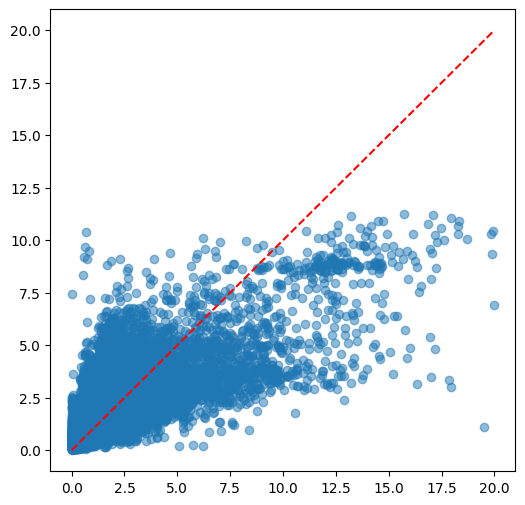

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.show()
